# Capstone Project Part 6: Transforming Text

**Authur:** Kate Meredith 

**Date:** September-November 2022

**Notebook #**: 6 of

## Background

**Source:** Data was collected from [CoffeeReview.com](https://www.coffeereview.com/). See prior notebooks for details on scraping, cleaning and compilation. This notebook focuses on tokenizing the review text.

**Goal:** Experiment with text tokenizing methods to compare baseline effectiveness across the tested tools.

## References

- Used this [article](https://stackoverflow.com/questions/37080612/pandas-dataframe-filter-regex) for searching for specific text in columns
- Used BrainStation notebook on working with text
- Referenced this [article](https://danilzherebtsov.medium.com/continuous-data-stratification-c121fc91964b) for strategy on how to stratefy train/val/test split where target is a continuous variable
- Referenced this [article](https://stackoverflow.com/questions/61158963/how-to-sort-the-result-by-pandas-value-counts) to see value_counts sorted by column value instead of frequency
- Natural Language Toolkit (NLTK): Bird, Steven, Edward Loper and Ewan Klein (2009), Natural Language Processing with Python. O’Reilly Media Inc.

In [1]:
#Importing libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gensim

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from tempfile import mkdtemp
from scipy.spatial.distance import cosine as cosine_distance
from gensim.utils import simple_preprocess
from sklearn.ensemble import RandomForestRegressor

### Importing and previewing data

In [2]:
coffee = pd.read_csv('coffee.csv')

In [3]:
coffee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6557 entries, 0 to 6556
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   coffee_name    6557 non-null   object 
 1   roaster_name   6557 non-null   object 
 2   month          6557 non-null   int64  
 3   year           6557 non-null   int64  
 4   bean_agtron    6557 non-null   int64  
 5   ground_agtron  6557 non-null   int64  
 6   aroma          6557 non-null   int64  
 7   acidity        6557 non-null   int64  
 8   body           6557 non-null   int64  
 9   flavor         6557 non-null   int64  
 10  aftertaste     6557 non-null   int64  
 11  roaster_lat    6557 non-null   float64
 12  roaster_lon    6557 non-null   float64
 13  origin_lat     6557 non-null   float64
 14  origin_lon     6557 non-null   float64
 15  p1             6557 non-null   object 
 16  p2             6557 non-null   object 
 17  p3             6557 non-null   object 
 18  overall_

In [4]:
coffee.shape

(6557, 19)

In [5]:
coffee.head()

,coffee_name,roaster_name,month,year,bean_agtron,ground_agtron,aroma,acidity,body,flavor,aftertaste,roaster_lat,roaster_lon,origin_lat,origin_lon,p1,p2,p3,overall_score
0,Colombia Cerro Azul Enano,Equator Coffees,10,2022,60,77,9,9,9,9,8,37.973535,-122.531087,4.099917,-72.908813,Blind Assessment: Elegantly fruit- and cocoa-t...,Notes: Produced at Finca Cerro Azul (also owne...,The Bottom Line: This rare Enano (dwarf Geish...,94
1,Peru Incahuasi,Press Coffee,10,2022,58,78,9,9,9,9,8,33.448437,-112.074141,-6.869970,-75.045851,"Blind Assessment: Gently fruit-toned, integrat...",Notes: Produced at Incahuasi Farm from trees o...,The Bottom Line: Laden with tropical fruit not...,94
2,Colombia Aponte’s Guardians,Press Coffee,10,2022,59,77,9,9,8,9,8,33.448437,-112.074141,4.099917,-72.908813,"Blind Assessment: Richly sweet, spice-toned. L...",Notes: Produced at Aponte Farm from an undiscl...,"The Bottom Line: A balanced, inviting washed C...",93
3,Nicaragua Flor de Dalia Natural,Equator Coffees,10,2022,62,78,8,8,9,9,8,37.973535,-122.531087,12.609016,-85.293691,"Blind Assessment: Gently fruit-forward, sweetl...",Notes: Produced by smallholding members of the...,"The Bottom Line: A refreshing, very sweet natu...",92
4,Ethiopia Bench Maji Geisha G1 Natural,Taster's Coffee,10,2022,65,81,9,9,8,9,8,25.072134,121.679919,10.211670,38.652120,"Blind Assessment: Gently sweet-tart, floral-to...",Notes: Produced from trees of the admired bota...,The Bottom Line: A quietly confident natural-p...,93


In [6]:
coffee.describe()

,month,year,bean_agtron,ground_agtron,aroma,acidity,body,flavor,aftertaste,roaster_lat,roaster_lon,origin_lat,origin_lon,overall_score
count,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000,6557.000000
mean,6.642062,2013.102181,52.229983,67.668598,8.360988,7.904224,8.086472,8.361598,7.795638,37.027419,-64.412448,10.198811,-12.161417,90.873723
std,3.437202,6.719059,8.411739,12.936090,0.927393,1.023060,0.871203,1.065692,0.874365,9.504209,81.708964,12.709097,68.848718,4.089739
min,1.000000,1997.000000,11.000000,12.000000,2.000000,1.000000,4.000000,1.000000,2.000000,-37.824425,-159.582761,-30.292848,-155.428370,60.000000
25%,4.000000,2008.000000,48.000000,60.000000,8.000000,8.000000,8.000000,8.000000,7.000000,32.840162,-117.423510,1.441968,-79.366697,90.000000
50%,7.000000,2014.000000,54.000000,71.000000,9.000000,8.000000,8.000000,9.000000,8.000000,39.049011,-89.383761,10.211670,7.540121,92.000000
75%,10.000000,2019.000000,58.000000,77.000000,9.000000,9.000000,9.000000,9.000000,8.000000,43.074761,-72.815099,13.800038,38.652120,93.000000
max,12.000000,2022.000000,91.000000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,64.837845,152.952215,52.380033,153.125616,98.000000


## Preprocessing

Before we create our X and y, there are some repeated words that appear in the `p1`, `p2`, and `p3` paragraphs as headers. In most reviews, these paragrapsh correspond to:

- p1: Blind Assessment
- p2: Notes
- p3: The Bottom Line OR Who Should Drink it

We'll first check to see if these paragraphs do contain the information we expect.

Checking the composition of paragraphs:

In [7]:
#see how many of p1 paragraphs reference which type of information
len(coffee.loc[coffee['p1'].str.contains(r'(Blind Assessment).*')])

/var/folders/jm/x73vvhpx2cd14qw0zx2ccfsc0000gn/T/ipykernel_24643/1218255241.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  len(coffee.loc[coffee['p1'].str.contains(r'(Blind Assessment).*')])


6557

In [8]:
#see how many of p2 paragraphs reference which type of information
len(coffee.loc[coffee['p2'].str.contains(r'(Notes).*')])

/var/folders/jm/x73vvhpx2cd14qw0zx2ccfsc0000gn/T/ipykernel_24643/3921903414.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  len(coffee.loc[coffee['p2'].str.contains(r'(Notes).*')])


6557

In [9]:
#see how many of p3 paragraphs reference which type of information
len(coffee.loc[coffee['p3'].str.contains(r'(The Bottom).*')])

/var/folders/jm/x73vvhpx2cd14qw0zx2ccfsc0000gn/T/ipykernel_24643/984657743.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  len(coffee.loc[coffee['p3'].str.contains(r'(The Bottom).*')])


2728

In [10]:
#see how many of p3 paragraphs reference which type of information
len(coffee.loc[coffee['p3'].str.contains(r'(Who Should).*')])

/var/folders/jm/x73vvhpx2cd14qw0zx2ccfsc0000gn/T/ipykernel_24643/2101417195.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  len(coffee.loc[coffee['p3'].str.contains(r'(Who Should).*')])


3777

As expected, paragraphs 1 and 2 contain consistent data, and paragraph 3 is split. We'll remove "Blind Assessment", "The Bottom Line", "Who Should Drink it" and "Notes" from our bag of words as they appear in every review and therefore won't be useful in distinguishing content.

Getting rid of repeat words:

In [11]:
#splitting out paragraph review score labels
coffee[['ba','p1']] = coffee['p1'].str.split(":", n=1, expand=True)

In [12]:
#splitting out paragraph review score labels
coffee[['N','p2']] = coffee['p2'].str.split(":", n=1, expand=True)

In [13]:
#splitting out paragraph review score labels
coffee[['tbl','p3']] = coffee['p3'].str.split(":", n=1, expand=True)

In [14]:
#drop unneeded holding columns
coffee.drop(['ba', 'N', 'tbl'], axis=1, inplace=True)

In [15]:
#checking for nan
coffee.isna().sum()

coffee_name      0
roaster_name     0
month            0
year             0
bean_agtron      0
ground_agtron    0
aroma            0
acidity          0
body             0
flavor           0
aftertaste       0
roaster_lat      0
roaster_lon      0
origin_lat       0
origin_lon       0
p1               0
p2               0
p3               3
overall_score    0
dtype: int64

In [16]:
#removing headers generated a couple nan rows
#drop rows missing value in overall_score column 
coffee.dropna(subset = ['p3'], inplace=True)

In [17]:
len(coffee)

6554

### Stratifying Data

Given that we can't simply stratefy our train, validation and test splits on a continuous target variable, adding a categorical value corresponding to `overall_score`. This allows train, val, test to be stratefied, allowing for even distribution of values for training, validation and testing. We'll drop our temporary extra y column before running any tests.

We're going to use a bit more robust mapper in this notebook than the last because of how many scores are clustered in the 80 and 90s.

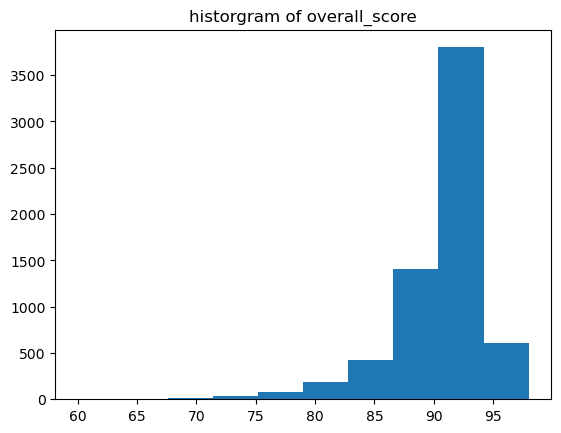

In [18]:
#plot y distribution
plt.figure()
plt.hist(coffee['overall_score'])
plt.title('historgram of overall_score')
plt.show()

In [19]:
#creating categorical mapper
score_mapper = {range(0,70):'one', range(70,80):'two', range(80,85):'three', range(85,90):'four', range(90,95):'five', range(95,101): 'six'}

In [20]:
coffee['overall_cat'] = coffee['overall_score'].replace(score_mapper)

In [21]:
coffee['overall_cat'].unique()

array(['five', 'six', 'four', 'three', 'two', 'one'], dtype=object)

In [22]:
#verifying splits appear accurate
coffee[['overall_score', 'overall_cat']].sample(20)

,overall_score,overall_cat
4342,91,five
4199,96,six
1654,92,five
1941,95,six
1823,90,five
6190,86,four
3309,91,five
3517,89,four
1286,92,five
6395,78,two


### Creating X and y:

To evaluate how effective the text transformation methods are, we'll create our X and y data.

- y or target = `overall_score`
- X = remaining data, but to tokenize we'll break work with `p1`,`p2`, and `p3` one at a time.

In [23]:
X = coffee.drop(['overall_score', 'overall_cat'], axis = 1)

In [24]:
X.shape

(6554, 18)

In [25]:
y = coffee[['overall_score','overall_cat']]

In [26]:
y.shape

(6554, 2)

Creating train, validation and testing splits:

In [27]:
y['overall_cat']

0       five
1       five
2       five
3       five
4       five
        ... 
6552     two
6553     two
6554    five
6555    four
6556    four
Name: overall_cat, Length: 6554, dtype: object

In [28]:
#create train/test split, using 20% given dataset size

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y['overall_cat'], test_size=0.2)

In [29]:
#create train/validate split, using 20% given dataset size

X_remain, X_val, y_remain, y_val = train_test_split(X_train, y_train, stratify = y_train['overall_cat'], test_size=0.2)

Below, verifying the shape of our new remain, validation and test splits.

In [30]:
X_train.shape

(5243, 18)

In [31]:
X_remain.shape

(4194, 18)

In [32]:
X_val.shape

(1049, 18)

In [33]:
X_test.shape

(1311, 18)

In [34]:
y_train.shape

(5243, 2)

In [35]:
y_remain.shape

(4194, 2)

In [36]:
y_val.shape

(1049, 2)

In [37]:
y_test.shape

(1311, 2)

In [38]:
y_test.head()

,overall_score,overall_cat
4697,94,five
4343,92,five
4991,89,four
4641,90,five
2551,93,five


Do my train, val, test splits have similar distributions?

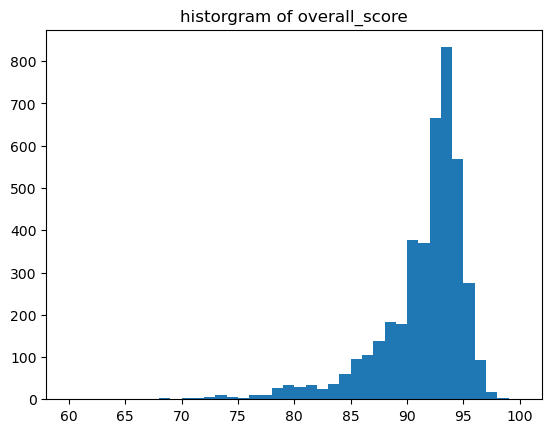

In [39]:
#plot y val distribution
plt.figure()
plt.hist(y_remain['overall_score'], range(60,101))
plt.title('historgram of overall_score')
plt.show()

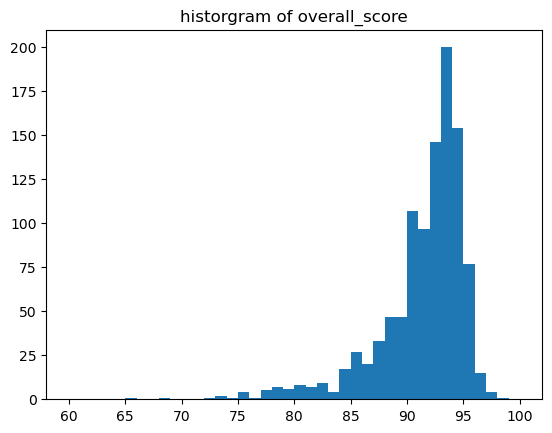

In [40]:
#plot y val distribution
plt.figure()
plt.hist(y_val['overall_score'], range(60,101))
plt.title('historgram of overall_score')
plt.show()

The test group looks a bit different but each group does have the range of values with somewhat similar distributions.

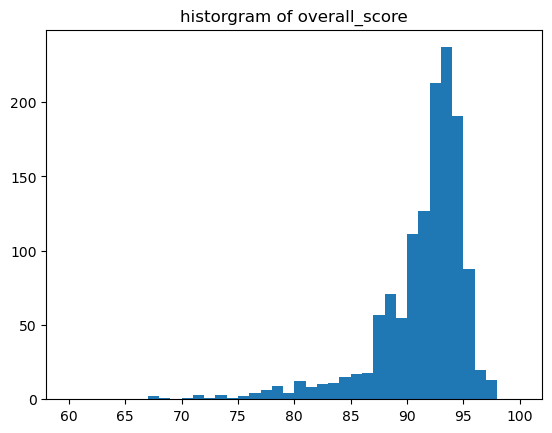

In [41]:
#plot y val distribution
plt.figure()
plt.hist(y_test['overall_score'], range(60,101))
plt.title('historgram of overall_score')
plt.show()

The distributions aren't perfect, but even enough. Now we'll drop the categorical column `overall_cat` so that we are just working with our continous targe `overall_score`.

In [42]:
y_train = y_train['overall_score']

In [43]:
y_remain = y_remain['overall_score']

In [44]:
y_val = y_val['overall_score']

In [45]:
y_test = y_test['overall_score']

Verifying y shapes as expected with categorical version dropped:

In [46]:
y_train.head()

2756    95
6239    83
2248    91
5480    91
5354    96
Name: overall_score, dtype: int64

In [47]:
y_remain.head()

3228    94
5548    94
1437    94
5606    90
6325    79
Name: overall_score, dtype: int64

In [48]:
y_val.head()

1417    93
837     93
1512    93
6094    78
4333    89
Name: overall_score, dtype: int64

In [49]:
y_test.head()

4697    94
4343    92
4991    89
4641    90
2551    93
Name: overall_score, dtype: int64

## Transforming the Text

Below we'll try a few different text transformation methods. If time allows, we may revisit these and try additional methods to improve transformations.

### Bag of Words with CountVectorizer()

We'll start with CountVectorizer().

Creating bag of words on `p1` and graphing the most popular words:

/Users/katemondal/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


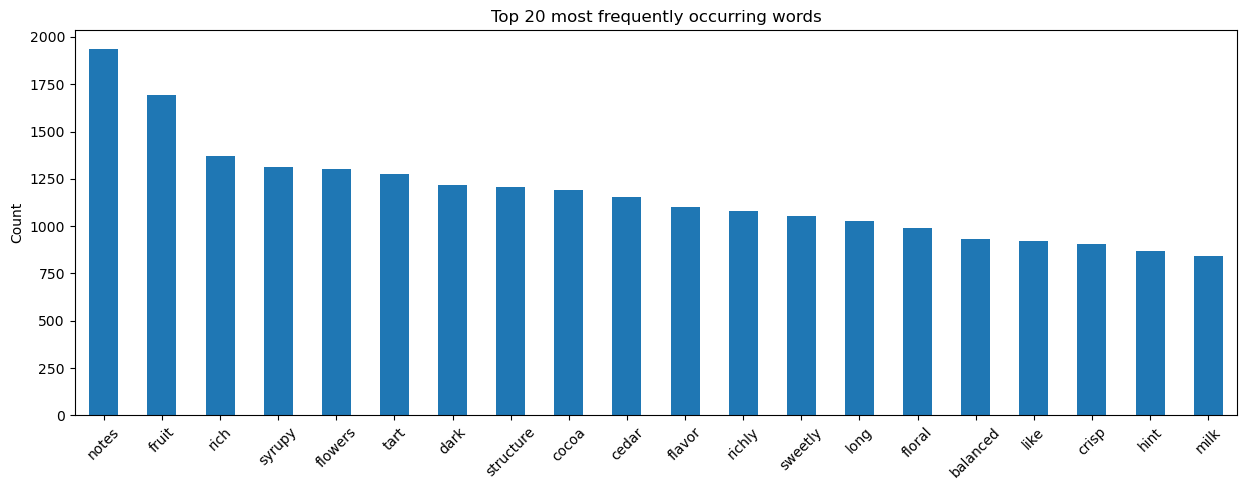

In [50]:
# 1. Instantiate with starting parameters
bagofwords_p1 = CountVectorizer(stop_words='english', min_df=5, max_features=500, max_df=2000)

# 2. Fit 
bagofwords_p1.fit(X_remain["p1"])

# 3. Transform
p1_remain_transform = bagofwords_p1.transform(X_remain["p1"])
p1_val_transform = bagofwords_p1.transform(X_val["p1"])
p1_test_transform = bagofwords_p1.transform(X_test["p1"])

#the following looks at the 20 most popular words from paragraph 1
word_counts = pd.DataFrame(
    {"counts": p1_remain_transform.toarray().sum(axis=0)},
    index=bagofwords_p1.get_feature_names()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

Looking at the most popular words to see if anything stands out. We might benefit from stemming or lemmatization (see similar words like 'pleasant', 'pleasantly', and 'pleasing'.

In [51]:
bagofwords_p1.get_feature_names()

/Users/katemondal/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['85',
 '88',
 '89',
 '90',
 '91',
 '92',
 'acid',
 'acidy',
 'admired',
 'aftertaste',
 'agave',
 'almond',
 'amber',
 'anise',
 'apple',
 'apricot',
 'aromatic',
 'aromatics',
 'astringency',
 'astringent',
 'attractive',
 'authority',
 'b70',
 'backgrounded',
 'baker',
 'baking',
 'balance',
 'balanced',
 'banana',
 'barrel',
 'bean',
 'bergamot',
 'berries',
 'berry',
 'best',
 'big',
 'bit',
 'bitter',
 'bitterish',
 'bitterness',
 'bittersweet',
 'black',
 'blackberry',
 'blend',
 'blood',
 'blooming',
 'blossom',
 'blueberry',
 'bodied',
 'body',
 'brandy',
 'brazil',
 'brewed',
 'brewing',
 'bright',
 'brightly',
 'brisk',
 'brittle',
 'brown',
 'buoyant',
 'burned',
 'butter',
 'butterscotch',
 'buttery',
 'cacao',
 'candied',
 'candy',
 'cappuccino',
 'capsule',
 'caramel',
 'caramelly',
 'carbon',
 'cardamom',
 'carob',
 'carried',
 'carries',
 'carry',
 'carrying',
 'cashew',
 'cedar',
 'cedary',
 'centered',
 'centers',
 'character',
 'charred',
 'cherry',
 'cherryish',
 '

In [52]:
#checking how many words there are
len(bagofwords_p1.get_feature_names())

500

In [53]:
# 1. Instantiate the model
p1_model = LinearRegression()

# 2. Fit the model
p1_model.fit(p1_remain_transform, y_remain)

LinearRegression()

In [54]:
# 3. Scoring the training model
print(f'The R2 score for p1 CountVectorizer training data is: {p1_model.score(p1_remain_transform, y_remain)}')

# 3. Scoring the validation model
print(f'The R2 score for p1 CountVectorizer validation data is: {p1_model.score(p1_val_transform, y_val)}')

The R2 score for p1 CountVectorizer training data is: 0.7987438466559169
The R2 score for p1 CountVectorizer validation data is: 0.707765987696589


Creating bag of words for `p2` with CountVectorizer and graphing:

/Users/katemondal/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


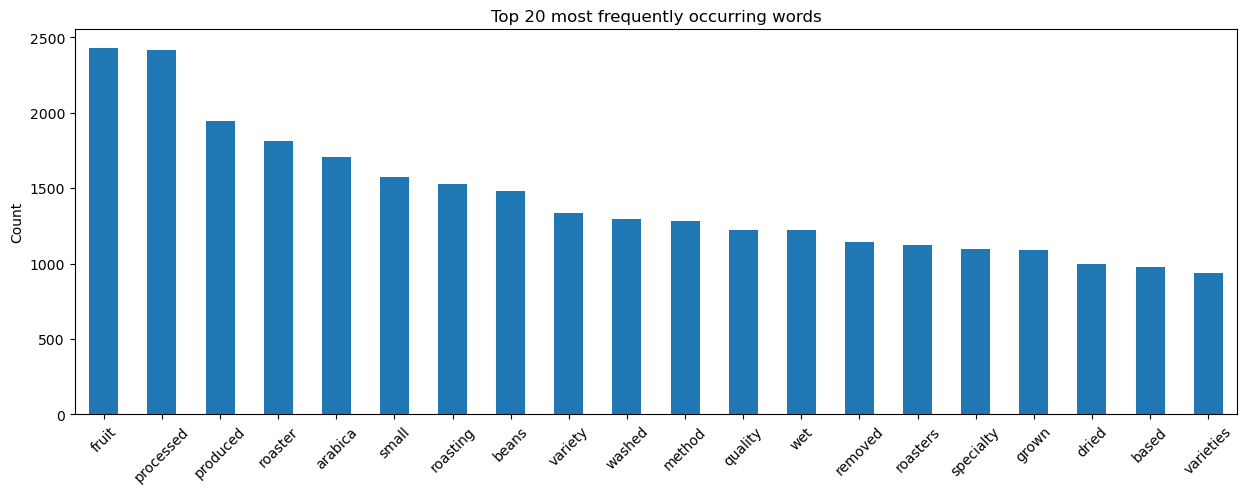

In [55]:
# 1. Instantiate 
bagofwords_p2 = CountVectorizer(stop_words='english', min_df=5, max_features=500, max_df=2000)

# 2. Fit 
bagofwords_p2.fit(X_remain["p2"])

# 3. Transform
p2_remain_transform = bagofwords_p2.transform(X_remain["p2"])
p2_val_transform = bagofwords_p2.transform(X_val["p2"])
p2_test_transform = bagofwords_p2.transform(X_test["p2"])

#the following looks at the 20 most popular words from paragraph 2

word_counts = pd.DataFrame(
    {"counts": p2_remain_transform.toarray().sum(axis=0)},
    index=bagofwords_p2.get_feature_names()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [56]:
bagofwords_p2.get_feature_names()

/Users/katemondal/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['000',
 '0626',
 '100',
 '11',
 '1282',
 '1990',
 '2005',
 '2007',
 '2010',
 '2016',
 '2017',
 '2018',
 '2019',
 '2020',
 '256',
 '30',
 '433',
 '454',
 '4627',
 '503',
 '5282',
 '608',
 '678',
 '763',
 '800',
 '866',
 '877',
 '879',
 '886',
 '888',
 '916',
 'aa',
 'acidity',
 'active',
 'addition',
 'admired',
 'africa',
 'agricultural',
 'air',
 'alliance',
 'allowed',
 'america',
 'american',
 'anaerobic',
 'angeles',
 'appear',
 'approach',
 'arabica',
 'area',
 'aroma',
 'aromatic',
 'artisan',
 'asia',
 'associated',
 'auction',
 'available',
 'award',
 'bag',
 'barista',
 'based',
 'batch',
 'batches',
 'bay',
 'bean',
 'beaned',
 'beans',
 'best',
 'better',
 'big',
 'bird',
 'black',
 'blend',
 'blends',
 'bold',
 'botanical',
 'bourbon',
 'boutique',
 'brand',
 'brazil',
 'brew',
 'brewing',
 'bring',
 'brothers',
 'burundi',
 'business',
 'cafe',
 'café',
 'california',
 'called',
 'capsule',
 'case',
 'catuai',
 'caturra',
 'celebrated',
 'central',
 'certified',
 'chain',

This group may also benefit from stemming. There are also a few words that might be worth getting rid of if possible, like "www" as many of these paragraphs send people to the coffee roaster's website.

In [57]:
len(bagofwords_p2.get_feature_names())

500

In [58]:
# 1. Instantiate the model
p2_model = LinearRegression()

# 2. Fit the model
p2_model.fit(p2_remain_transform, y_remain)

LinearRegression()

In [59]:
# 3. Scoring the training model
print(f'The R2 score for p2 CountVectorizor training data is: {p2_model.score(p2_remain_transform, y_remain)}')

# 3. Scoring the validation model
print(f'The R2 score for p2 CountVectorizor validation data is: {p2_model.score(p2_val_transform, y_val)}')

The R2 score for p2 CountVectorizor training data is: 0.6565871317426836
The R2 score for p2 CountVectorizor validation data is: 0.5290575256155232


Creating bag of words for `p3` with CountVectorizer and graphing:

/Users/katemondal/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


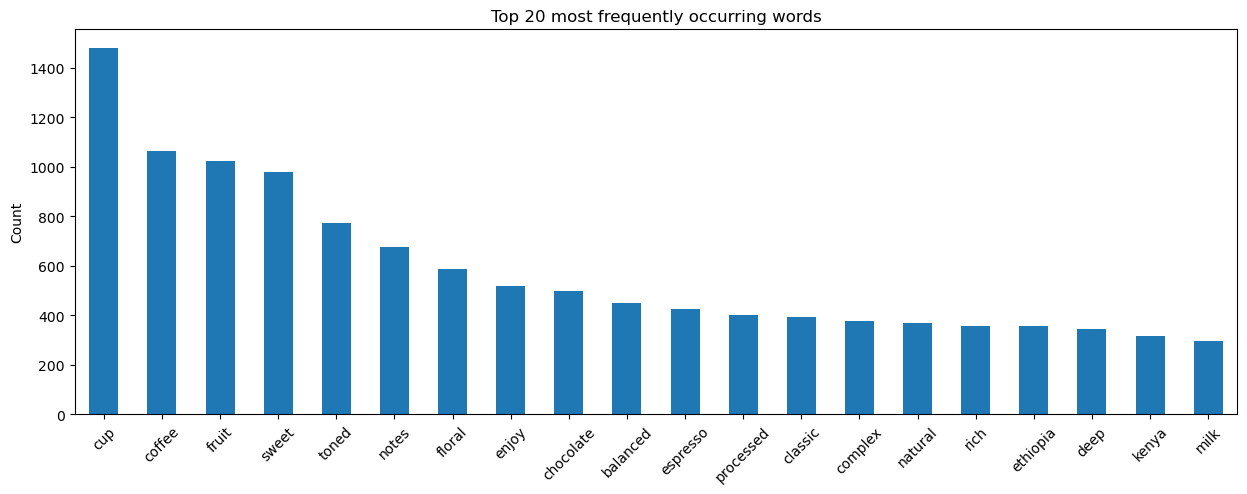

In [60]:
# 1. Instantiate 
bagofwords_p3 = CountVectorizer(stop_words='english', min_df=5, max_features=500, max_df=2000)

# 2. Fit 
bagofwords_p3.fit(X_remain["p3"])

# 3. Transform
p3_remain_transform = bagofwords_p3.transform(X_remain["p3"])
p3_val_transform = bagofwords_p3.transform(X_val["p3"])
p3_test_transform = bagofwords_p3.transform(X_test["p3"])

#the following looks at the 20 most popular words from paragraph 3

word_counts = pd.DataFrame(
    {"counts": p3_remain_transform.toarray().sum(axis=0)},
    index=bagofwords_p3.get_feature_names()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [61]:
bagofwords_p3.get_feature_names()

/Users/katemondal/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['accessible',
 'acid',
 'acidity',
 'acidy',
 'adventurers',
 'aficionados',
 'africa',
 'alive',
 'america',
 'american',
 'anaerobic',
 'animated',
 'appeal',
 'appealing',
 'appreciate',
 'arabica',
 'aroma',
 'aromas',
 'aromatic',
 'aromatically',
 'aromatics',
 'assertive',
 'associated',
 'attractive',
 'austere',
 'authoritative',
 'authority',
 'avoid',
 'avoiders',
 'baking',
 'balance',
 'balanced',
 'ballast',
 'beautifully',
 'berry',
 'best',
 'better',
 'beverages',
 'big',
 'bit',
 'bitter',
 'bitterness',
 'bittersweet',
 'black',
 'blend',
 'blends',
 'bodied',
 'body',
 'bold',
 'bomb',
 'bourbon',
 'bracing',
 'brandy',
 'brazil',
 'breakfast',
 'brew',
 'brewed',
 'brewing',
 'bright',
 'brightly',
 'brightness',
 'brisk',
 'briskly',
 'burned',
 'burundi',
 'cacao',
 'caffeine',
 'cappuccino',
 'caramel',
 'caramelly',
 'carry',
 'case',
 'cedar',
 'celebrated',
 'centered',
 'central',
 'certified',
 'character',
 'characteristic',
 'characterized',
 'chocolate'

This group seems to do pretty well with the basic cleaning, may also benefit from stemming.

In [62]:
len(bagofwords_p3.get_feature_names())

500

In [63]:
# 1. Instantiate the model
p3_model = LinearRegression()

# 2. Fit the model
p3_model.fit(p3_remain_transform, y_remain)

LinearRegression()

In [64]:
# 3. Scoring the training model
print(f'The R2 score for p3 CountVectorizor training data is: {p3_model.score(p3_remain_transform, y_remain)}')

# 3. Scoring the validation model
print(f'The R2 score for p3 CountVectorizor validation data is: {p3_model.score(p3_val_transform, y_val)}')

The R2 score for p3 CountVectorizor training data is: 0.558840695865609
The R2 score for p3 CountVectorizor validation data is: 0.44898153028326726


### Text Transformation with TFIDF

Transforming `p1` paragraph with TFIDF and graphing:

/Users/katemondal/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


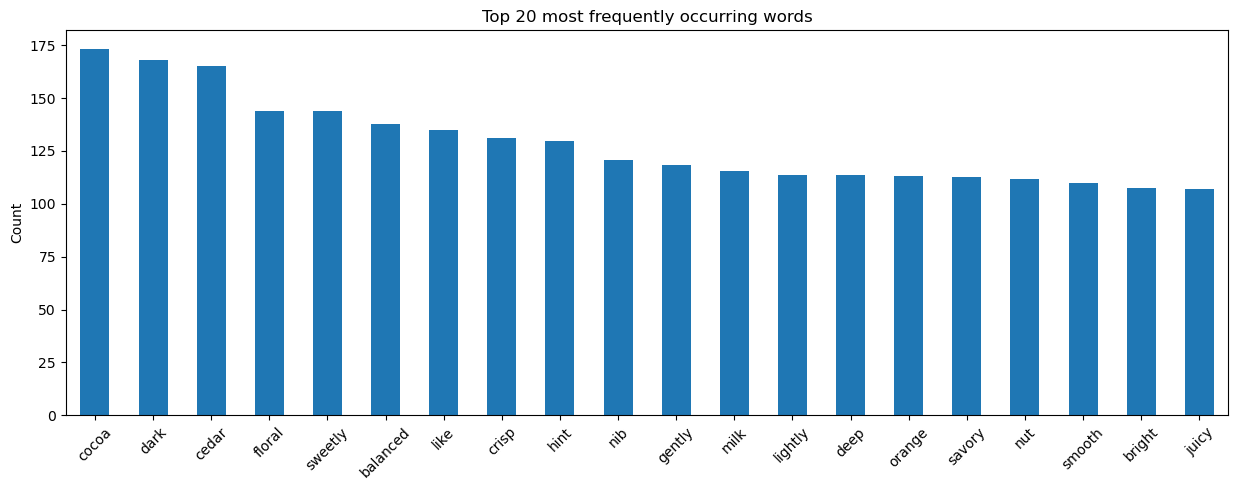

In [65]:
# 1. Instantiate 
tfidf_p1 = TfidfVectorizer(stop_words='english', min_df=5, max_df=1000, max_features=500)

# 2. Fit 
tfidf_p1.fit(X_remain["p1"])

# 3. Transform
tp1_remain_transform = tfidf_p1.transform(X_remain["p1"])
tp1_val_transform = tfidf_p1.transform(X_val["p1"])
tp1_test_transform = tfidf_p1.transform(X_test["p1"])

#the following looks at the 20 most popular words from paragraph 3

word_counts = pd.DataFrame(
    {"counts": tp1_remain_transform.toarray().sum(axis=0)},
    index=tfidf_p1.get_feature_names()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [66]:
tfidf_p1.get_feature_names()

/Users/katemondal/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['85',
 '88',
 '89',
 '90',
 '91',
 '92',
 'acid',
 'acidy',
 'admired',
 'aftertaste',
 'agave',
 'almond',
 'amber',
 'amplified',
 'anise',
 'apple',
 'apricot',
 'aromatic',
 'aromatics',
 'astringency',
 'astringent',
 'attractive',
 'authority',
 'b70',
 'backgrounded',
 'baker',
 'baking',
 'balance',
 'balanced',
 'banana',
 'barrel',
 'bean',
 'bergamot',
 'berries',
 'berry',
 'best',
 'big',
 'bit',
 'bitter',
 'bitterish',
 'bitterness',
 'bittersweet',
 'black',
 'blackberry',
 'blend',
 'blood',
 'blooming',
 'blossom',
 'blueberry',
 'bodied',
 'body',
 'brandy',
 'brazil',
 'brewed',
 'brewing',
 'bright',
 'brightly',
 'brisk',
 'brittle',
 'brown',
 'buoyant',
 'burned',
 'butter',
 'butterscotch',
 'buttery',
 'cacao',
 'candied',
 'candy',
 'cappuccino',
 'capsule',
 'caramel',
 'caramelly',
 'carbon',
 'cardamom',
 'carob',
 'carried',
 'carries',
 'carry',
 'carrying',
 'cashew',
 'cedar',
 'cedary',
 'centered',
 'centers',
 'character',
 'charred',
 'cherry',
 '

In [67]:
len(tfidf_p1.get_feature_names())

500

In [68]:
# 1. Instantiate the model
tp1_model = LinearRegression()

# 2. Fit the model
tp1_model.fit(tp1_remain_transform, y_remain)

LinearRegression()

In [69]:
# 3. Scoring the training model
print(f'The R2 score for p1 with TFIDF training data is: {tp1_model.score(tp1_remain_transform, y_remain)}')

# 3. Scoring the validation model
print(f'The R2 score for p1 with TFIDF validation data is: {tp1_model.score(tp1_val_transform, y_val)}')

The R2 score for p1 with TFIDF training data is: 0.8125191084577797
The R2 score for p1 with TFIDF validation data is: 0.7226693477257896


Transforming `p2` paragraph with TFIDF:

/Users/katemondal/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


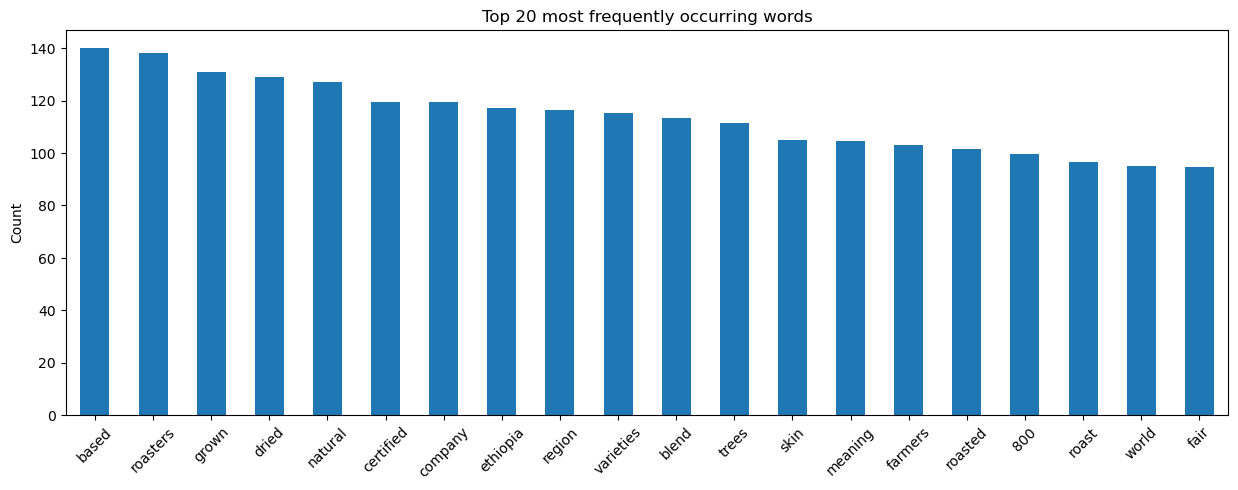

In [70]:
# 1. Instantiate 
tfidf_p2 = TfidfVectorizer(stop_words='english', min_df=5, max_df=1000, max_features=500)

# 2. Fit 
tfidf_p2.fit(X_remain["p2"])

# 3. Transform
tp2_remain_transform = tfidf_p2.transform(X_remain["p2"])
tp2_val_transform = tfidf_p2.transform(X_val["p2"])
tp2_test_transform = tfidf_p2.transform(X_test["p2"])

#the following looks at the 20 most popular words from paragraph 3

word_counts = pd.DataFrame(
    {"counts": tp2_remain_transform.toarray().sum(axis=0)},
    index=tfidf_p2.get_feature_names()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [71]:
tfidf_p2.get_feature_names()

/Users/katemondal/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['000',
 '0626',
 '100',
 '11',
 '1282',
 '1990',
 '2005',
 '2007',
 '2010',
 '2016',
 '2017',
 '2018',
 '2019',
 '2020',
 '256',
 '30',
 '433',
 '454',
 '4627',
 '503',
 '5282',
 '608',
 '678',
 '763',
 '800',
 '866',
 '877',
 '879',
 '886',
 '888',
 '916',
 'aa',
 'acidity',
 'active',
 'addition',
 'admired',
 'africa',
 'agricultural',
 'air',
 'alliance',
 'allowed',
 'america',
 'american',
 'anaerobic',
 'angeles',
 'appear',
 'approach',
 'area',
 'aroma',
 'aromatic',
 'artisan',
 'asia',
 'associated',
 'auction',
 'available',
 'award',
 'bag',
 'barista',
 'based',
 'batch',
 'batches',
 'bay',
 'bean',
 'beaned',
 'best',
 'better',
 'big',
 'bird',
 'black',
 'blend',
 'blends',
 'bold',
 'botanical',
 'bourbon',
 'boutique',
 'brand',
 'brazil',
 'brew',
 'brewing',
 'bring',
 'brothers',
 'burundi',
 'business',
 'cafe',
 'café',
 'california',
 'called',
 'capsule',
 'case',
 'catuai',
 'caturra',
 'celebrated',
 'central',
 'certified',
 'chain',
 'challenges',
 'char

In [72]:
len(tfidf_p2.get_feature_names())

500

In [73]:
# 1. Instantiate the model
tp2_model = LinearRegression()

# 2. Fit the model
tp2_model.fit(tp2_remain_transform, y_remain)

LinearRegression()

In [74]:
# 3. Scoring the training model
print(f'The R2 score for p2 TFIDF training data is: {tp2_model.score(tp2_remain_transform, y_remain)}')

# 3. Scoring the validation model
print(f'The R2 score for p2 TFIDF validation data is: {tp2_model.score(tp2_val_transform, y_val)}')

The R2 score for p2 TFIDF training data is: 0.7076291253073965
The R2 score for p2 TFIDF validation data is: 0.5523411201524968


Transforming `p3` with TFIDF:

/Users/katemondal/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


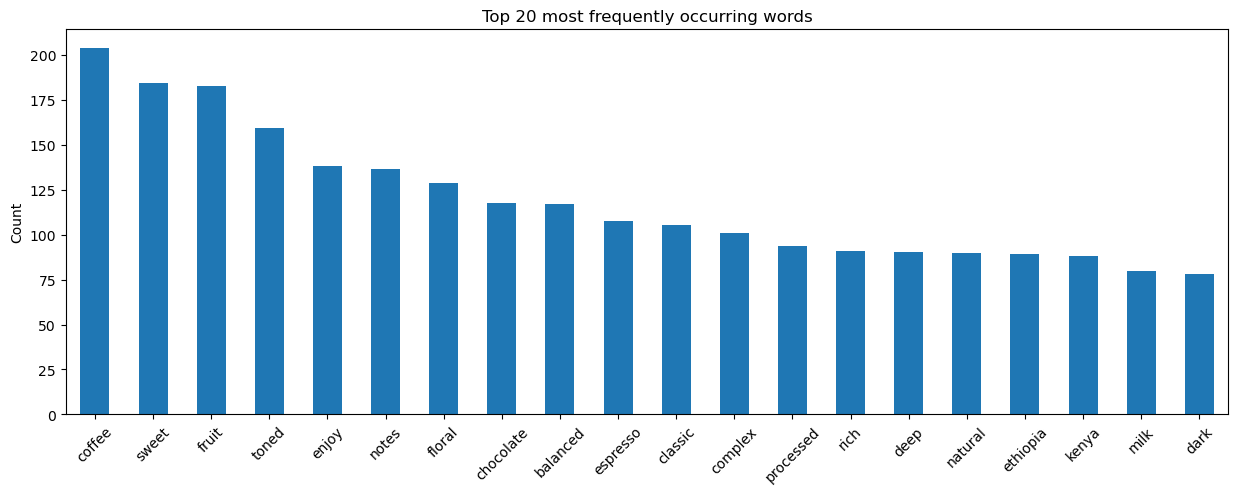

In [75]:
# 1. Instantiate 
tfidf_p3 = TfidfVectorizer(stop_words='english', min_df=5, max_df=1000, max_features=500)

# 2. Fit 
tfidf_p3.fit(X_remain["p3"])

# 3. Transform
tp3_remain_transform = tfidf_p3.transform(X_remain["p3"])
tp3_val_transform = tfidf_p3.transform(X_val["p3"])
tp3_test_transform = tfidf_p3.transform(X_test["p3"])

#the following looks at the 20 most popular words from paragraph 3

word_counts = pd.DataFrame(
    {"counts": tp3_remain_transform.toarray().sum(axis=0)},
    index=tfidf_p3.get_feature_names()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [76]:
tfidf_p3.get_feature_names()

/Users/katemondal/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['accessible',
 'acid',
 'acidity',
 'acidy',
 'adventurers',
 'aficionados',
 'africa',
 'alive',
 'america',
 'american',
 'anaerobic',
 'animated',
 'appeal',
 'appealing',
 'appreciate',
 'arabica',
 'aroma',
 'aromas',
 'aromatic',
 'aromatically',
 'aromatics',
 'assertive',
 'associated',
 'attractive',
 'austere',
 'authoritative',
 'authority',
 'avoid',
 'avoiders',
 'baking',
 'balance',
 'balanced',
 'ballast',
 'beautifully',
 'berry',
 'best',
 'better',
 'beverages',
 'big',
 'bit',
 'bitter',
 'bitterness',
 'bittersweet',
 'black',
 'blend',
 'blends',
 'bodied',
 'body',
 'bold',
 'bomb',
 'bourbon',
 'bracing',
 'brandy',
 'brazil',
 'breakfast',
 'brew',
 'brewed',
 'brewing',
 'bright',
 'brightly',
 'brightness',
 'brisk',
 'briskly',
 'burned',
 'burundi',
 'cacao',
 'caffeine',
 'cappuccino',
 'caramel',
 'caramelly',
 'carry',
 'case',
 'cedar',
 'celebrated',
 'centered',
 'central',
 'certified',
 'character',
 'characteristic',
 'characterized',
 'chocolate'

In [77]:
len(tfidf_p3.get_feature_names())

500

In [78]:
# 1. Instantiate the model
tp3_model = LinearRegression()

# 2. Fit the model
tp3_model.fit(tp3_remain_transform, y_remain)

LinearRegression()

In [79]:
# 3. Scoring the training model
print(f'The R2 score for p3 TFIDF training data is: {tp3_model.score(tp3_remain_transform, y_remain)}')

# 3. Scoring the validation model
print(f'The R2 score for p3 TFIDF validation data is: {tp3_model.score(tp3_val_transform, y_val)}')

The R2 score for p3 TFIDF training data is: 0.5997393528163876
The R2 score for p3 TFIDF validation data is: 0.5032059271066596


### Exploring Different Parameters for Text Transformation

For now, we'll explore these a bit at a time. Time allowing, we can run more robust versions of these that account for how changing the parameters affects the performance of other parameters.

Exploring impact of changing min_df:

In [80]:
for i in range(1,30,2):

    bagofwords_p1 = CountVectorizer(stop_words='english', min_df=i, max_features=500, max_df=2000)

    bagofwords_p1.fit(X_remain["p1"])

    p1_remain_transform = bagofwords_p1.transform(X_remain["p1"])
    p1_val_transform = bagofwords_p1.transform(X_val["p1"])
    p1_test_transform = bagofwords_p1.transform(X_test["p1"])

    p1_model = LinearRegression()

    p1_model.fit(p1_remain_transform, y_remain)

    print(f'min_df: {i}')
    print(f'The R2 score for p1 CountVectorizer training data is: {p1_model.score(p1_remain_transform, y_remain)}')
    print(f'The R2 score for p1 CountVectorizer validation data is: {p1_model.score(p1_val_transform, y_val)}')

min_df: 1
The R2 score for p1 CountVectorizer training data is: 0.7987438466559169
The R2 score for p1 CountVectorizer validation data is: 0.707765987696589
min_df: 3
The R2 score for p1 CountVectorizer training data is: 0.7987438466559169
The R2 score for p1 CountVectorizer validation data is: 0.707765987696589
min_df: 5
The R2 score for p1 CountVectorizer training data is: 0.7987438466559169
The R2 score for p1 CountVectorizer validation data is: 0.707765987696589
min_df: 7
The R2 score for p1 CountVectorizer training data is: 0.7987438466559169
The R2 score for p1 CountVectorizer validation data is: 0.707765987696589
min_df: 9
The R2 score for p1 CountVectorizer training data is: 0.7987438466559169
The R2 score for p1 CountVectorizer validation data is: 0.707765987696589
min_df: 11
The R2 score for p1 CountVectorizer training data is: 0.7987438466559169
The R2 score for p1 CountVectorizer validation data is: 0.707765987696589
min_df: 13
The R2 score for p1 CountVectorizer training d

Experimenting with best max_feature range:

In [81]:
for i in range(100,1000,50):

    bagofwords_p1 = CountVectorizer(stop_words='english', min_df=7, max_features=i, max_df=2000)

    bagofwords_p1.fit(X_remain["p1"])

    p1_remain_transform = bagofwords_p1.transform(X_remain["p1"])
    p1_val_transform = bagofwords_p1.transform(X_val["p1"])
    p1_test_transform = bagofwords_p1.transform(X_test["p1"])

    p1_model = LinearRegression()

    p1_model.fit(p1_remain_transform, y_remain)

    print(f'max_features: {i}')
    print(f'The R2 score for p1 CountVectorizer training data is: {p1_model.score(p1_remain_transform, y_remain)}')
    print(f'The R2 score for p1 CountVectorizer validation data is: {p1_model.score(p1_val_transform, y_val)}')

max_features: 100
The R2 score for p1 CountVectorizer training data is: 0.5845683044095128
The R2 score for p1 CountVectorizer validation data is: 0.5615876836163554
max_features: 150
The R2 score for p1 CountVectorizer training data is: 0.6211100914795422
The R2 score for p1 CountVectorizer validation data is: 0.593164518099117
max_features: 200
The R2 score for p1 CountVectorizer training data is: 0.657378926845982
The R2 score for p1 CountVectorizer validation data is: 0.624404709358393
max_features: 250
The R2 score for p1 CountVectorizer training data is: 0.6755604619559963
The R2 score for p1 CountVectorizer validation data is: 0.6474500924259273
max_features: 300
The R2 score for p1 CountVectorizer training data is: 0.6956530738646058
The R2 score for p1 CountVectorizer validation data is: 0.6569893942063785
max_features: 350
The R2 score for p1 CountVectorizer training data is: 0.7430988973313981
The R2 score for p1 CountVectorizer validation data is: 0.6876929116725279
max_fea

Modifying the number of `max_features` seems to matter a lot for validation data. 

In [82]:
for i in range(100,20000,1000):

    bagofwords_p1 = CountVectorizer(stop_words='english', min_df=7, max_features=500, max_df=i)

    bagofwords_p1.fit(X_remain["p1"])

    p1_remain_transform = bagofwords_p1.transform(X_remain["p1"])
    p1_val_transform = bagofwords_p1.transform(X_val["p1"])
    p1_test_transform = bagofwords_p1.transform(X_test["p1"])

    p1_model = LinearRegression()

    p1_model.fit(p1_remain_transform, y_remain)

    print(f'max_df: {i}')
    print(f'The R2 score for p1 CountVectorizer training data is: {p1_model.score(p1_remain_transform, y_remain)}')
    print(f'The R2 score for p1 CountVectorizer validation data is: {p1_model.score(p1_val_transform, y_val)}')

max_df: 100
The R2 score for p1 CountVectorizer training data is: 0.7138835785062609
The R2 score for p1 CountVectorizer validation data is: 0.5446949615384327
max_df: 1100
The R2 score for p1 CountVectorizer training data is: 0.7895114535294598
The R2 score for p1 CountVectorizer validation data is: 0.7009651185604839
max_df: 2100
The R2 score for p1 CountVectorizer training data is: 0.7987438466559169
The R2 score for p1 CountVectorizer validation data is: 0.707765987696589
max_df: 3100
The R2 score for p1 CountVectorizer training data is: 0.8037691536254195
The R2 score for p1 CountVectorizer validation data is: 0.7152172118343548
max_df: 4100
The R2 score for p1 CountVectorizer training data is: 0.8046869437686786
The R2 score for p1 CountVectorizer validation data is: 0.7253109382471906
max_df: 5100
The R2 score for p1 CountVectorizer training data is: 0.8046869437686786
The R2 score for p1 CountVectorizer validation data is: 0.7253109382471906
max_df: 6100
The R2 score for p1 Cou

Max_df appears to best around 3100 and after that stops improving.

Testing with these parameters:

In [83]:
bagofwords_p1 = CountVectorizer(stop_words='english', min_df=7, max_features=500, max_df=3100)

bagofwords_p1.fit(X_remain["p1"])

p1_remain_transform = bagofwords_p1.transform(X_remain["p1"])
p1_val_transform = bagofwords_p1.transform(X_val["p1"])
p1_test_transform = bagofwords_p1.transform(X_test["p1"])

p1_model = LinearRegression()

p1_model.fit(p1_remain_transform, y_remain)

print(f'The R2 score for p1 CountVectorizer training data is: {p1_model.score(p1_remain_transform, y_remain)}')
print(f'The R2 score for p1 CountVectorizer validation data is: {p1_model.score(p1_val_transform, y_val)}')

The R2 score for p1 CountVectorizer training data is: 0.8037691536254195
The R2 score for p1 CountVectorizer validation data is: 0.7152172118343548


Doing similar thing with TFIDF:

In [84]:
for i in range(1,30,2):
    
    tfidf_p1 = TfidfVectorizer(stop_words='english', min_df=i, max_df=1000, max_features=500)

    tfidf_p1.fit(X_remain["p1"])

    tp1_remain_transform = tfidf_p1.transform(X_remain["p1"])
    tp1_val_transform = tfidf_p1.transform(X_val["p1"])
    tp1_test_transform = tfidf_p1.transform(X_test["p1"])

    tp1_model = LinearRegression()

    tp1_model.fit(tp1_remain_transform, y_remain)

    print(f'min_df value: {i}')
    print(f'The R2 score for p3 TFIDF training data is: {tp1_model.score(tp1_remain_transform, y_remain)}')
    print(f'The R2 score for p3 TFIDF validation data is: {tp1_model.score(tp1_val_transform, y_val)}')

min_df value: 1
The R2 score for p3 TFIDF training data is: 0.8126368885135553
The R2 score for p3 TFIDF validation data is: 0.7215670897514638
min_df value: 3
The R2 score for p3 TFIDF training data is: 0.8124886534976515
The R2 score for p3 TFIDF validation data is: 0.7225815456982614
min_df value: 5
The R2 score for p3 TFIDF training data is: 0.8125191084577797
The R2 score for p3 TFIDF validation data is: 0.7226693477257896
min_df value: 7
The R2 score for p3 TFIDF training data is: 0.812467711015639
The R2 score for p3 TFIDF validation data is: 0.7228109773812387
min_df value: 9
The R2 score for p3 TFIDF training data is: 0.8121311551027947
The R2 score for p3 TFIDF validation data is: 0.7227764998673385
min_df value: 11
The R2 score for p3 TFIDF training data is: 0.8121311551027947
The R2 score for p3 TFIDF validation data is: 0.7227764998673385
min_df value: 13
The R2 score for p3 TFIDF training data is: 0.8124886534976515
The R2 score for p3 TFIDF validation data is: 0.72258154

This one also seems to do better with lower min_df value, peaking around 7 (although there's not a huge difference at lower scores).

Experimenting with max_features:

In [85]:
for i in range(1,1000,100):
    
    tfidf_p1 = TfidfVectorizer(stop_words='english', min_df=7, max_features=i, max_df=1000)

    tfidf_p1.fit(X_remain["p1"])

    tp1_remain_transform = tfidf_p1.transform(X_remain["p1"])
    tp1_val_transform = tfidf_p1.transform(X_val["p1"])
    tp1_test_transform = tfidf_p1.transform(X_test["p1"])

    tp1_model = LinearRegression()

    tp1_model.fit(tp1_remain_transform, y_remain)

    print(f'max_features value: {i}')
    print(f'The R2 score for p3 TFIDF training data is: {tp1_model.score(tp1_remain_transform, y_remain)}')
    print(f'The R2 score for p3 TFIDF validation data is: {tp1_model.score(tp1_val_transform, y_val)}')

max_features value: 1
The R2 score for p3 TFIDF training data is: 0.0008233734946869742
The R2 score for p3 TFIDF validation data is: 0.004755971495381095
max_features value: 101
The R2 score for p3 TFIDF training data is: 0.6080247663742322
The R2 score for p3 TFIDF validation data is: 0.5898099911709411
max_features value: 201
The R2 score for p3 TFIDF training data is: 0.6818642646030171
The R2 score for p3 TFIDF validation data is: 0.6516512560811138
max_features value: 301
The R2 score for p3 TFIDF training data is: 0.7250895814723675
The R2 score for p3 TFIDF validation data is: 0.6842490966603891
max_features value: 401
The R2 score for p3 TFIDF training data is: 0.7941613743998215
The R2 score for p3 TFIDF validation data is: 0.7259004787867099
max_features value: 501
The R2 score for p3 TFIDF training data is: 0.8124948500009724
The R2 score for p3 TFIDF validation data is: 0.7225920447801952
max_features value: 601
The R2 score for p3 TFIDF training data is: 0.829822633953595

This one also seems to peak around 500.

Exploring max_df:

In [86]:
for i in range(1000,10000,500):
    
    tfidf_p1 = TfidfVectorizer(stop_words='english', min_df=7, max_features=500, max_df=i)

    tfidf_p1.fit(X_remain["p1"])

    tp1_remain_transform = tfidf_p1.transform(X_remain["p1"])
    tp1_val_transform = tfidf_p1.transform(X_val["p1"])
    tp1_test_transform = tfidf_p1.transform(X_test["p1"])

    tp1_model = LinearRegression()

    tp1_model.fit(tp1_remain_transform, y_remain)

    print(f'max_df value: {i}')
    print(f'The R2 score for p3 TFIDF training data is: {tp1_model.score(tp1_remain_transform, y_remain)}')
    print(f'The R2 score for p3 TFIDF validation data is: {tp1_model.score(tp1_val_transform, y_val)}')

max_df value: 1000
The R2 score for p3 TFIDF training data is: 0.812467711015639
The R2 score for p3 TFIDF validation data is: 0.7228109773812387
max_df value: 1500
The R2 score for p3 TFIDF training data is: 0.8229372671863048
The R2 score for p3 TFIDF validation data is: 0.7398550715758314
max_df value: 2000
The R2 score for p3 TFIDF training data is: 0.8229753213382736
The R2 score for p3 TFIDF validation data is: 0.7403906209885065
max_df value: 2500
The R2 score for p3 TFIDF training data is: 0.8251018622956279
The R2 score for p3 TFIDF validation data is: 0.7409974709669931
max_df value: 3000
The R2 score for p3 TFIDF training data is: 0.8264659257558234
The R2 score for p3 TFIDF validation data is: 0.7455317478481428
max_df value: 3500
The R2 score for p3 TFIDF training data is: 0.8259067763842558
The R2 score for p3 TFIDF validation data is: 0.7425578502119905
max_df value: 4000
The R2 score for p3 TFIDF training data is: 0.8255976244617038
The R2 score for p3 TFIDF validation 

This one seems to peak around 4000.

### Word Embedding:

As a third potential approach to vectorizing our text, we'll employ word embedding with Gensim and lexvec.

In [87]:
#import word vectors to reference
model = gensim.models.KeyedVectors.load_word2vec_format(
    'lexvec.enwiki+newscrawl.300d.W.pos.vectors', binary=False
)

In [88]:
#borrowing this code from representation learning module with BrainStation

def sentence2vec(text):
    
    """
    Embed a sentence by averaging the word vectors of the tokenized text. 
    Out-of-vocabulary words are replaced by the zero-vector.
    -----
    
    Input: text (string)
    Output: embedding vector (np.array)
    """
    tokenized = simple_preprocess(text)
    
    word_embeddings = [np.zeros(300)]
    
    for word in tokenized:
        # if the word is in the model then embed
        if word in model:
            vector = model[word]
        # add zeros for out-of-vocab words
        else:
            vector = np.zeros(300)
            
        word_embeddings.append(vector)
    
    # average the word vectors
    sentence_embedding = np.stack(word_embeddings).mean(axis=0)
     
    return sentence_embedding

In [89]:
#apply embedding to our 1st paragraph
X_remain_emb_p1 = X_remain['p1'].apply(sentence2vec)

X_remain_emb_p1.head()

3228    [0.04794187177097998, -0.055307821155740663, 0...
5548    [0.024664736879793436, -0.01622345568122048, 0...
1437    [0.06544413928722226, -0.022984093986451626, 0...
5606    [0.04210041105226778, -0.03522105772486504, 0....
6325    [0.03457193696522154, -0.02157574844750343, 0....
Name: p1, dtype: object

In [90]:
#check shape
X_remain_emb_p1.shape

(4194,)

In [91]:
#turn into format we can use with predictive model
X_remain_emb_p1 = np.array(X_remain_emb_p1.tolist())

In [92]:
X_remain_emb_p1.shape

(4194, 300)

In [93]:
emb_model_p1 = LinearRegression()
emb_model_p1.fit(X_remain_emb_p1, y_remain)

print(f'The R2 score for p1 embedded word training data is: {emb_model_p1.score(X_remain_emb_p1, y_remain)}')

The R2 score for p1 embedded word training data is: 0.7587037952393767


In [94]:
X_val_emb_p1 = X_val['p1'].apply(sentence2vec)
X_test_emb_p1 = X_test['p1'].apply(sentence2vec)

In [95]:
X_val_emb_p1 = np.array(X_val_emb_p1.tolist())
X_test_emb_p1 = np.array(X_test_emb_p1.tolist())

In [96]:
print(f'The R2 score for p1 embedded word validation data is: {emb_model_p1.score(X_val_emb_p1, y_val)}')

The R2 score for p1 embedded word validation data is: 0.6841136993763604


RandomForest on embedded model:

In [97]:
rf_emb_model_p1 = RandomForestRegressor()
rf_emb_model_p1.fit(X_remain_emb_p1, y_remain)

print(f'The R2 score for p1 embedded word training data is: {rf_emb_model_p1.score(X_remain_emb_p1, y_remain)}')

The R2 score for p1 embedded word training data is: 0.9577468535251463


In [98]:
print(f'The R2 score for p1 embedded word validation data is: {rf_emb_model_p1.score(X_val_emb_p1, y_val)}')

The R2 score for p1 embedded word validation data is: 0.7045285272500286


## Comparing Best Versions

**Evaluating with Linear Regression**
 
For sake of comparison, we'll just use `p1` to compare.

CountVectorizor() with linear regression:

In [106]:
bagofwords_p1 = CountVectorizer(stop_words='english', min_df=7, max_features=500, max_df=3100)

bagofwords_p1.fit(X_remain["p1"])

p1_remain_transform = bagofwords_p1.transform(X_remain["p1"])
p1_val_transform = bagofwords_p1.transform(X_val["p1"])
p1_test_transform = bagofwords_p1.transform(X_test["p1"])

p1_model = LinearRegression()

p1_model.fit(p1_remain_transform, y_remain)

print(f'The R2 score for p1 CountVectorizer training data is: {p1_model.score(p1_remain_transform, y_remain)}')
print(f'The R2 score for p1 CountVectorizer validation data is: {p1_model.score(p1_val_transform, y_val)}')

CV_P1_LR_R2_val = p1_model.score(p1_val_transform, y_val)
print(f'CountVectorizer p1 LR model validation R2: {CV_P1_LR_R2_val}')

The R2 score for p1 CountVectorizer training data is: 0.8037691536254195
The R2 score for p1 CountVectorizer validation data is: 0.7152172118343548
CountVectorizer p1 LR model validation R2: 0.7152172118343548


TfidfVectorizer() with linear regression:

In [108]:
tfidf_p1 = TfidfVectorizer(stop_words='english', min_df=7, max_features=500, max_df=4000)

tfidf_p1.fit(X_remain["p1"])

tp1_remain_transform = tfidf_p1.transform(X_remain["p1"])
tp1_val_transform = tfidf_p1.transform(X_val["p1"])
tp1_test_transform = tfidf_p1.transform(X_test["p1"])

tp1_model = LinearRegression()

tp1_model.fit(tp1_remain_transform, y_remain)

print(f'The R2 score for p3 TFIDF training data is: {tp1_model.score(tp1_remain_transform, y_remain)}')
print(f'The R2 score for p3 TFIDF validation data is: {tp1_model.score(tp1_val_transform, y_val)}')

TFIDF_P1_LR_R2_val = tp1_model.score(tp1_val_transform, y_val)
print(f'TFIDF p1 LR model validation R2: {TFIDF_P1_LR_R2_val}')

The R2 score for p3 TFIDF training data is: 0.8255976244617038
The R2 score for p3 TFIDF validation data is: 0.7474397968861889
TFIDF p1 LR model validation R2: 0.7474397968861889


Word Embed with linear regression():

**Evalutating with Random Forest** 

CountVectorizer() with Random Forest(): 

In [109]:
p1_rf_model = RandomForestRegressor()

p1_rf_model.fit(p1_remain_transform, y_remain)

print(f'The R2 RandomForest score for p1 CountVectorizer training data is: {p1_rf_model.score(p1_remain_transform, y_remain)}')
print(f'The R2 RandomForest score for p1 CountVectorizer validation data is: {p1_rf_model.score(p1_val_transform, y_val)}')

CV_P1_RF_R2_val = p1_rf_model.score(p1_val_transform, y_val)
print(f'CountVectorizer p1 Random Forest validation R2: {CV_P1_RF_R2_val}')

The R2 RandomForest score for p1 CountVectorizer training data is: 0.9566724814476659
The R2 RandomForest score for p1 CountVectorizer validation data is: 0.6954043051326689
CountVectorizer p1 Random Forest validation R2: 0.6954043051326689


TFIDF Vectorizer() with RandomForest():

In [102]:
tp1_rf_model = RandomForestRegressor()

tp1_rf_model.fit(tp1_remain_transform, y_remain)

print(f'The R2 score for p3 TFIDF training data is: {tp1_rf_model.score(tp1_remain_transform, y_remain)}')
print(f'The R2 score for p3 TFIDF validation data is: {tp1_rf_model.score(tp1_val_transform, y_val)}')

The R2 score for p3 TFIDF training data is: 0.9557824805066532
The R2 score for p3 TFIDF validation data is: 0.7018011447019732


Word Embed with Random Forest():